# Notes about the SAS's Course
## Statistics 1: Introduction to ANOVA, Regression, and Logistic Regression

This notes is based in the course materials, some codes and images are property . I made a Jupyter Notebook using JupiterLab with SAS University Edition. 

## 0. Script to setup the sesion
Run this script in the begining the each session to access the data in the correct way. 

In [1]:
ODS select none;

%let homefolder=/folders/myfolders/ECST142;
%let Cursofolder=/folders/myfolders/Statistics1_ANOVA_Regression_LogisticRegression/;

libname STAT1 "&homefolder";
libname Curso "&Cursofolder";



options fmtsearch=(stat1.myfmts);

proc format library=stat1.myfmts;
run;

/* create macro variables to hold the names of the interval and */
/* categorical variables used in the demo and practice programs */

%let interval=Gr_Liv_Area Basement_Area Garage_Area Deck_Porch_Area 
         Lot_Area Age_Sold Bedroom_AbvGr Total_Bathroom;

%let categorical=House_Style2 Overall_Qual2 Overall_Cond2 Fireplaces 
         Season_Sold Garage_Type_2 Foundation_2 Heating_QC 
         Masonry_Veneer Lot_Shape_2 Central_Air;

SAS Connection established. Subprocess id is 2118



## 5. Model Post-Fitting for Inference

* to verify these assumptions and diagnose problems that you encounter in linear regression. 
* to examine residuals.
* identify outliers that are numerically distant from the bulk of the data.
* identify influential observations that unduly affect the regression model.
* to diagnose collinearity to avoid inflated standard errors and parameter instability in the model.

### Examining Residuals
...

#### Demo: Examining Residual Plots Using PROC REG

we use PROC REG to create residual plots and other diagnostic plots. We use these plots to check our model assumptions and to check for outliers. First, to assess our model overall, we'll produce the eight default plots for fit diagnostics.


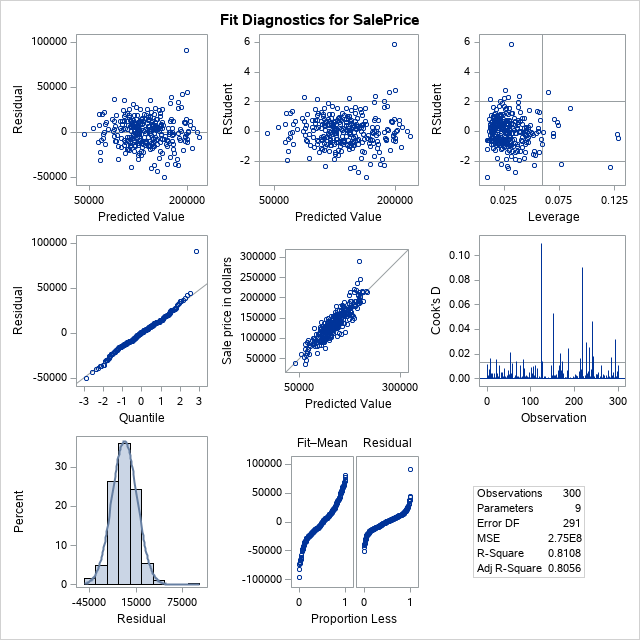
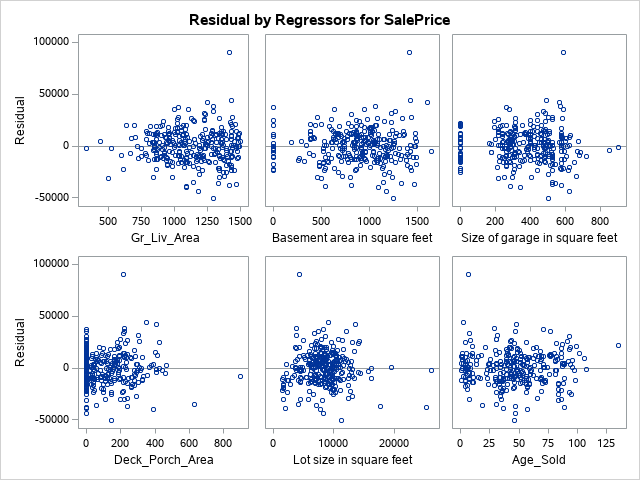
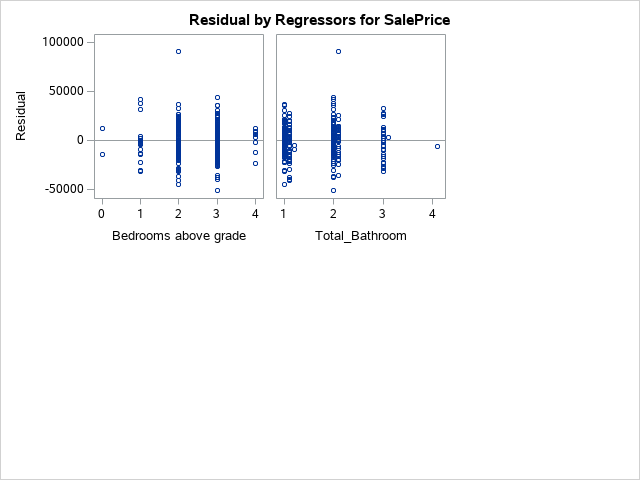

In [3]:
%let interval=Gr_Liv_Area Basement_Area Garage_Area Deck_Porch_Area 
         Lot_Area Age_Sold Bedroom_AbvGr Total_Bathroom ;

ods graphics on;
proc reg data=STAT1.ameshousing3;
    CONTINUOUS: model SalePrice 
                  = &interval;
    title 'SalePrice Model - Plots of Diagnostic Statistics';
run;
quit;

#### Practice: Using the Linear Regression Task to Examine Residuals
Run a regression on PctBodyFat2 in the bodyfat2 data set to examine residuals.
1. Use the Linear Regression task to run a regression model of PctBodyFat2 on Abdomen, Weight, Wrist, and Forearm. Create plots of the residuals by the four regressors and by the predicted values, and a normal Q-Q plot.
2. Do the residual plots indicate any problems with the constant variance assumption?
3. Are there any outliers indicated by the evidence in any of the residual plots?
4. Does the Q-Q plot indicate any problems with the normality assumption?


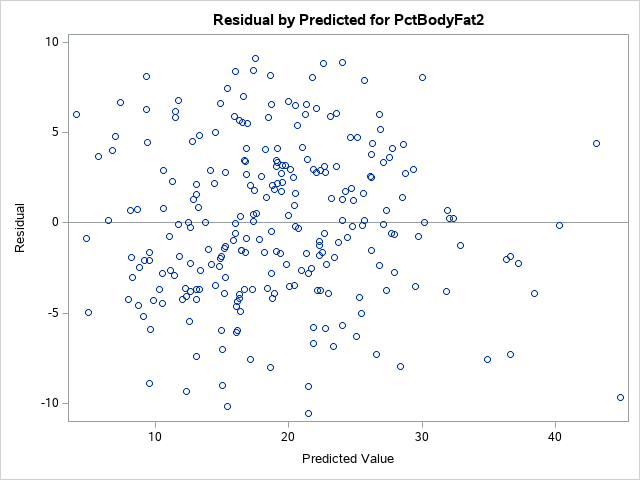
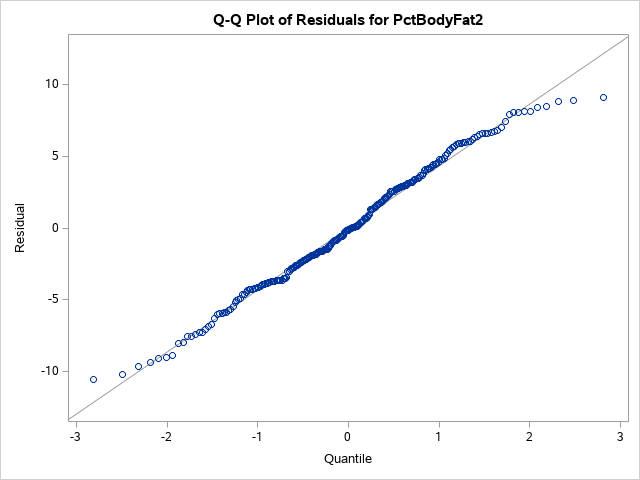
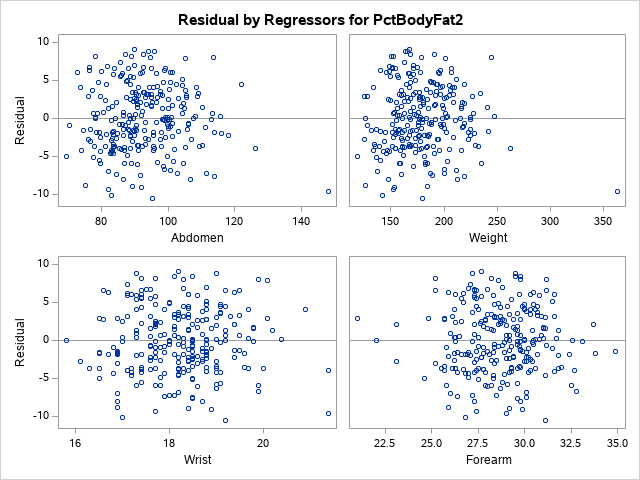

In [4]:
ods graphics / imagemap=on;

proc reg data=STAT1.BodyFat2 
         plots(only)=(QQ RESIDUALBYPREDICTED RESIDUALS);
   FORWARD: model PctBodyFat2 = Abdomen Weight Wrist Forearm;
   id Case;
   title 'FORWARD Model - Plots of Diagnostic Statistics';
run;
quit;

2. Do the residual plots indicate any problems with the constant variance assumption?: *It doesn't appear that the data violate the assumption of constant variance. Also, the residuals show nice random scatter and indicate no problem with model specification.*

3. Are there any outliers indicated by the evidence in any of the residual plots?: *There are a few outliers for Wrist and Forearm, and one clear outlier in both Abdomen and Weight.*

4. Does the Q-Q plot indicate any problems with the normality assumption?: *The normality assumption seems to be met.*

### Influential Observations

* The presence of influential observations or outliers can reveal problems with your model.

#### Checking for Outliers with STUDENT Residuals
...


#### Detecting Influential Observations with DFBETAS

* To help identify which parameter the observation might be influencing most, you can use DFBETAS.
* Sometimes, first use Cook's D to determine who is influential, and then use DFBETAS to determine which specific predictor is being influenced by that observation.
* Large DFBETAS indicate observations that are influential in estimating a given parameter. For DFBETAS, the general cutoff value is 2.

#### Demo: Looking for Influential Observations Using PROC GLMSELECT and PROC REG
1. We select a model by stepwise selection, PROC GLMSELECT. 
2. We use PROC REG to generate influence statistics and plots for the selected model and save the plot data to temporary output data sets.
3. We'll reference these data sets in the second part of the demonstration.


* automatically creates the macro variable _GLSIND, which stores a list of effects selected by PROC GLMSELECT. You can then reference the list as &_GLSIND in subsequent statements.
* ODS SELECT NONE, which suppresses the output.
* Cook's D is a measure of the simultaneous change in all parameter estimates when an observation is deleted. 


In [4]:
%let interval=Gr_Liv_Area Basement_Area Garage_Area Deck_Porch_Area 
         Lot_Area Age_Sold Bedroom_AbvGr Total_Bathroom ;

ods select none;
proc glmselect data=STAT1.ameshousing3 plots=all;
	STEPWISE: model SalePrice = &interval / selection=stepwise details=steps select=SL slentry=0.05 slstay=0.05;
	title "Stepwise Model Selection for SalePrice - SL 0.05";
run;
quit;
ods select all;

In [5]:
%put &_glsind; /*PROC GLMSELECT automatically saves the list of the chosen model effects as the _GLSIND macro variable*/


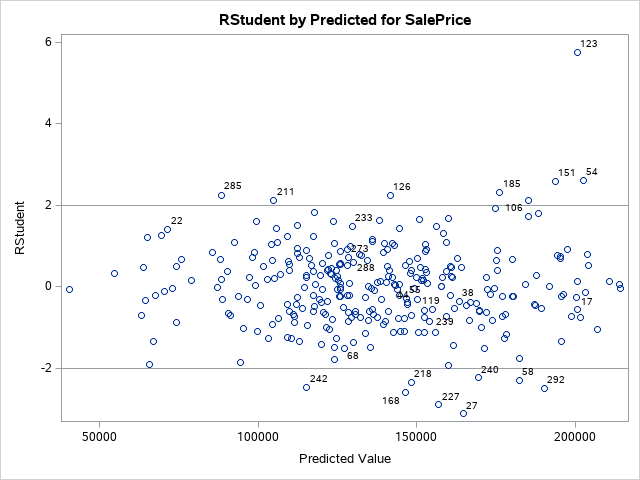
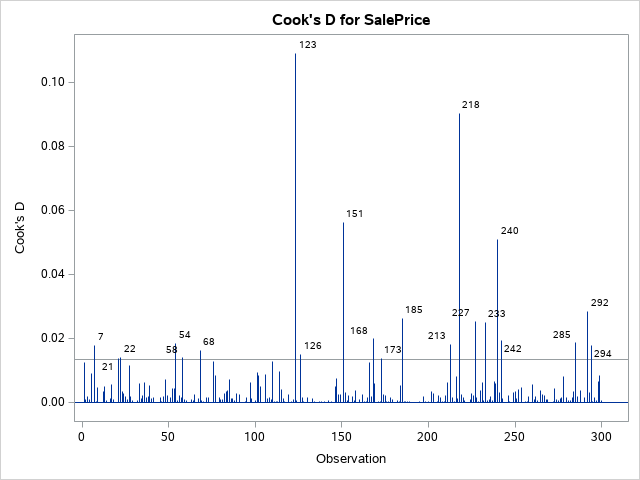
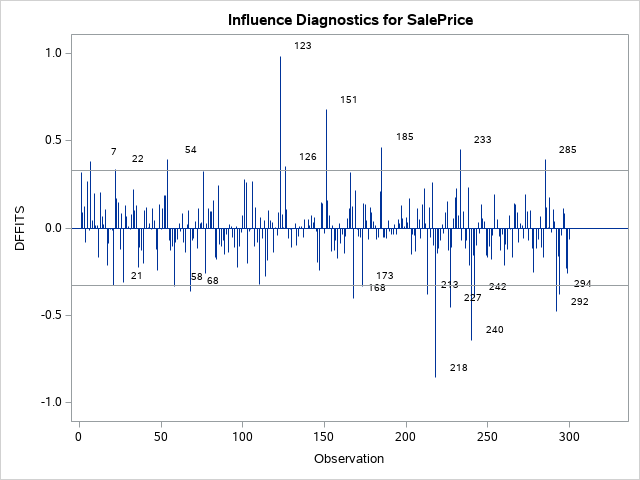
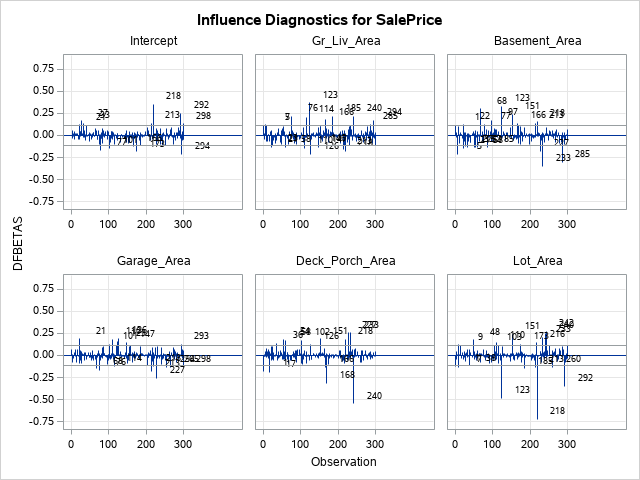
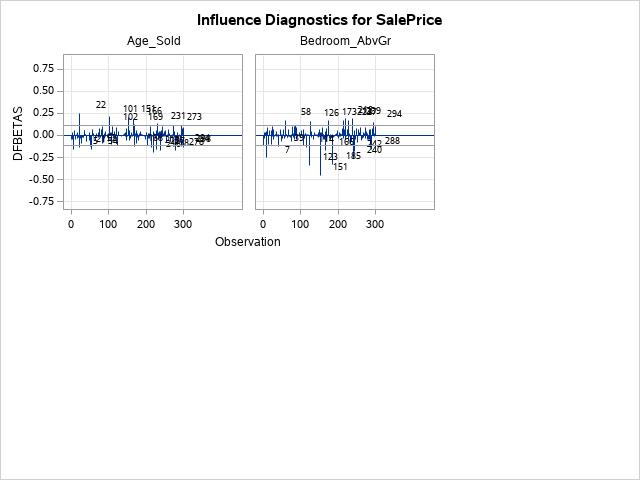

In [6]:
ods graphics on;
ods output RSTUDENTBYPREDICTED=Rstud 
           COOKSDPLOT=Cook
           DFFITSPLOT=Dffits 
           DFBETASPANEL=Dfbs;
           
proc reg data=STAT1.ameshousing3 
         plots(only label)=
              (RSTUDENTBYPREDICTED 
               COOKSD 
               DFFITS 
               DFBETAS);
    SigLimit: model SalePrice = &_GLSIND; 
    title 'SigLimit Model - Plots of Diagnostic Statistics';
run;
quit;

Take a look at the output data sets that we created in PROC GLMSELECT.

In [8]:
title;
proc print data=Rstud;
run;

proc print data=Cook;
run;

proc print data=Dffits;
run;

proc print data=Dfbs;
run;

data Dfbs01;
	set Dfbs (obs=300);
run;

data Dfbs02;
	set Dfbs (firstobs=301);
run;

data Dfbs2;
	update Dfbs01 Dfbs02;
	by Observation;
run;


data influential;
/*  Merge datasets from above.*/
    merge Rstud
          Cook 
          Dffits
          Dfbs2;
    by observation;

/*  Flag observations that have exceeded at least one cutpoint;*/
    if (ABS(Rstudent)>3) or (Cooksdlabel ne ' ') or Dffitsout then flag=1;
    array dfbetas{*} _dfbetasout: ;
    do i=2 to dim(dfbetas);
         if dfbetas{i} then flag=1;
    end;

/*  Set to missing values of influence statistics for those*/
/*  that have not exceeded cutpoints;*/
    if ABS(Rstudent)<=3 then RStudent=.;
    if Cooksdlabel eq ' ' then CooksD=.;

/*  Subset only observations that have been flagged.*/
    if flag=1;
    drop i flag;
run;

title;
proc print data=influential;
    id observation;
    var Rstudent CooksD Dffitsout _dfbetasout:; 
run;

Obs,Model,Dependent,RStudent,PredictedValue,outLevLabel,Observation
1,SigLimit,SalePrice,1.73092,185283.46,.,1
2,SigLimit,SalePrice,0.67964,180284.34,.,2
3,SigLimit,SalePrice,0.63948,104541.46,.,3
4,SigLimit,SalePrice,-0.58261,169597.56,.,4
5,SigLimit,SalePrice,1.32153,158490.53,.,5
6,SigLimit,SalePrice,-0.05738,125932.40,.,6
7,SigLimit,SalePrice,1.92473,174736.56,.,7
8,SigLimit,SalePrice,0.36232,153008.35,.,8
9,SigLimit,SalePrice,1.47568,156222.61,.,9
10,SigLimit,SalePrice,0.10202,140446.83,.,10


#### Practice: Using the Linear Regression Task to Generate Potential Outliers

Generate statistics for potential outliers in the bodyfat2 data set, write this data to an output data set, and print your results.

1. Use the Linear Regression task to run a regression model of PctBodyFat2 on Abdomen, Weight, Wrist, and Forearm. Create plots to identify potential influential observations that are based on the suggested cutoff values.


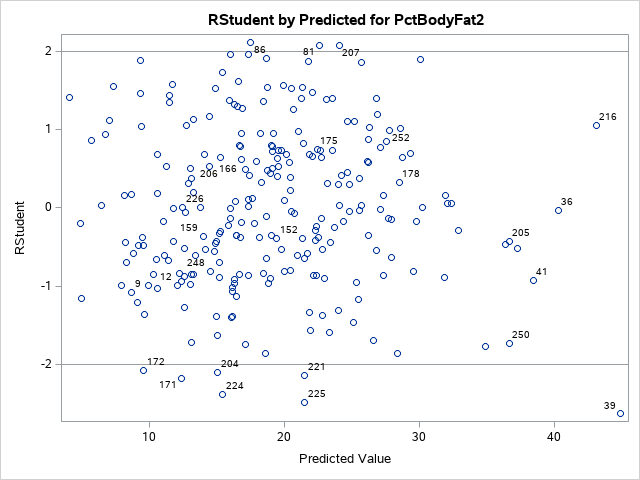
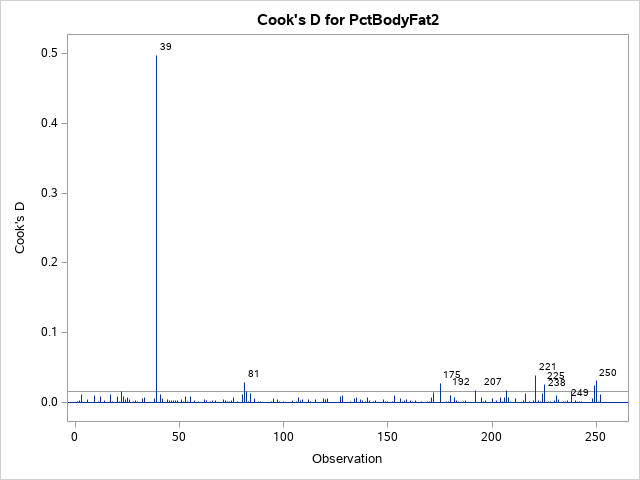
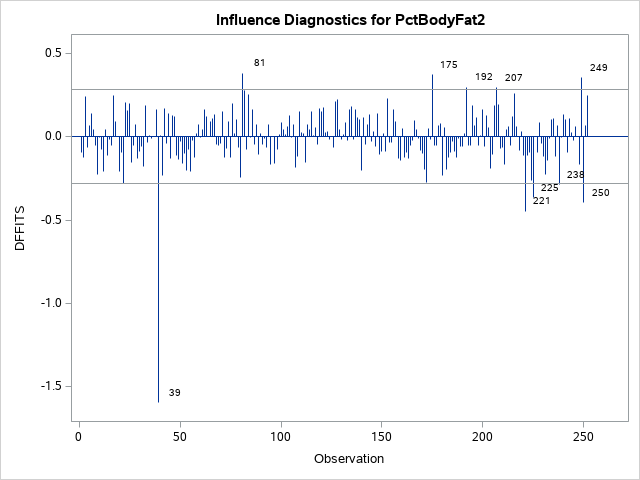
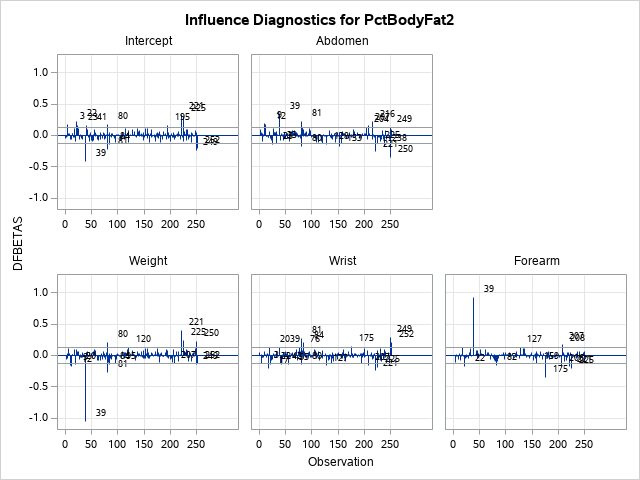

In [9]:
ods graphics on;
ods output RSTUDENTBYPREDICTED=Rstud 
           COOKSDPLOT=Cook
           DFFITSPLOT=Dffits 
           DFBETASPANEL=Dfbs;
proc reg data=STAT1.BodyFat2 
         plots(only label)=
              (RSTUDENTBYPREDICTED 
               COOKSD 
               DFFITS 
               DFBETAS);
   FORWARD: model PctBodyFat2
                 = Abdomen Weight Wrist Forearm;
   id Case; /*this lets the label with the case numbers in the plots*/
   title 'FORWARD Model - Plots of Diagnostic Statistics';
run;
quit;

* In the RStudent by Predicted for PctBodyFat2 scatter plot, only a modest number of observations are further than two standard error units from the mean of 0.
* In the Cook's D for PctBodyFat2 plot, there are 10 labeled outliers, but observation 39 is clearly the most extreme.
* In the Influence Diagnostics for PctBodyFat2 plot, the same observations are shown to be influential by the DFFITS statistic.
* In the panel plot, DFBETAS are particularly high for observation 39 on the parameters for Weight and Forearm circumference.

2. Write a DATA step to merge the four output data sets based on the common variable, observation. Add code to subset the data to select only the observations that are potentially influential outliers. Name the output data set influential. Submit the code and use the PRINT procedure or the Table Viewer in SAS Sudio to display the influential data set.

In [11]:
data influential;
/*  Merge datasets from above.*/
    merge Rstud
          Cook 
          Dffits
		  Dfbs;
    by observation;

/*  Flag observations that have exceeded at least one cutpoint;*/
    if (ABS(Rstudent)>3) or (Cooksdlabel ne ' ') or Dffitsout then flag=1;
    array dfbetas{*} _dfbetasout: ;
    do i=2 to dim(dfbetas);
        if dfbetas{i} then flag=1;
    end;

/*  Set to missing values of influence statistics for those*/
/*  who have not exceeded cutpoints;*/
    if ABS(Rstudent)<=3 then RStudent=.;
    if Cooksdlabel eq ' ' then CooksD=.;

/*  Subset only observations that have been flagged.*/
    if flag=1;
    drop i flag;
run;

proc print data=influential;
    id observation ID1;
    var Rstudent CooksD Dffitsout _dfbetasout:; 
run;

Observation,id1,RStudent,CooksD,DFFITSOUT,_DFBETASOUT1,_DFBETASOUT2,_DFBETASOUT3,_DFBETASOUT4,_DFBETASOUT5
3,3,.,.,.,0.17943,.,.,-0.12815,.
9,9,.,.,.,.,0.18911,-0.15600,.,.
12,12,.,.,.,.,0.18169,-0.18076,.,.
17,17,.,.,.,.,.,.,-0.20902,.
20,20,.,.,.,.,.,-0.13786,0.13273,.
22,22,.,.,.,0.22887,.,.,-0.14080,-0.16797
25,25,.,.,.,.,-0.14080,.,.,.
33,33,.,.,.,.,-0.12765,.,.,.
39,39,.,0.49632,-1.59408,-0.41792,0.33576,-1.05761,0.13217,0.93125
42,42,.,.,.,.,.,.,-0.13688,.


* The same observations appear in the PROC PRINT report as in the plots.
* Examine the values of observation 39 to see what is causing problems. You might find it interesting.

### Collinearity

We need to investigate the correlations between the variable score and the other interval variables that we're planning to use in our analysis. We'd like to make sure that none of our predictors provides redundant information, that is, that there's no multicollinearity.

#### Exploring Collinearity

* two or more predictor variables are highly correlated with each other. 
* collinearity would make the parameter estimates unstable and the standard errors large if all variables in the model were used as predictors.
* tools for collinearity detection such as Variance Inflation Factors.
* to deal with collinearity before using any automated model selection tool.
* collinearity increases the variance of the parameter estimates, which make them unstable.

#### Demo: Calculating Collinearity Diagnostics Using PROC REG

we use PROC CORR to investigate the correlations between the variable score and the other interval variables.

In [20]:
%let interval=Gr_Liv_Area Basement_Area Garage_Area Deck_Porch_Area 
         Lot_Area Age_Sold Bedroom_AbvGr Total_Bathroom ;

proc sort data=STAT1.ameshousing3 out=STAT1.ames_sorted;
    by PID;
run;

proc print data=STAT1.ameshousing3(obs=3);
title 'Let us check the file STAT1.ameshousing3';
run;
title '';


proc sort data=STAT1.amesaltuse; /*data from the other research group*/
    by PID;
run;



proc print data=STAT1.amesaltuse(obs=3);
title 'Let us check the file STAT1.amesaltuse';
run;
title '';


data amescombined;
    merge STAT1.ames_sorted STAT1.amesaltuse;
    by PID;
run;

title;
proc corr data=amescombined nosimple; /*nosimple supress the descrptive statistics table in the results*/
    var &interval;
    with score; /* for default SAS shows the correlations between all pairs of variables, here we only wants to see with Score variable*/
run;




The correlation with Basement_Area is large enough that they'll clearly provide redundant information about sale price and should not both be included in the same model. 

We're going to use PROC REG with the VIF option to further assess the collinearity problem and identify the predictors involved in the problem. 


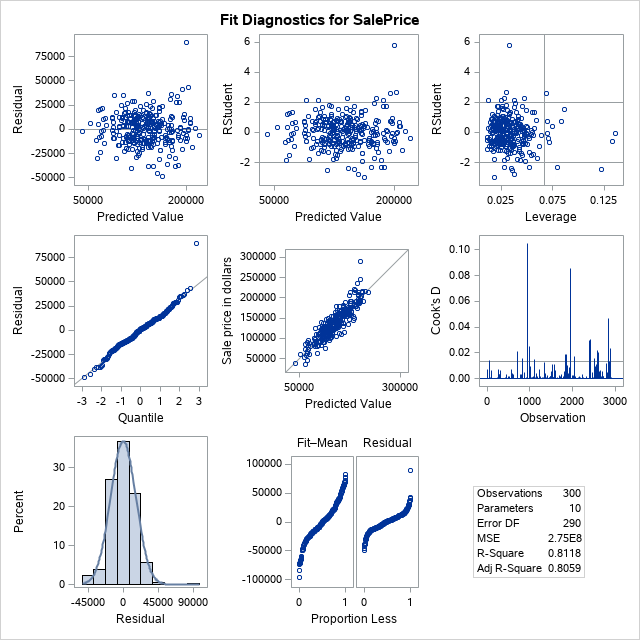
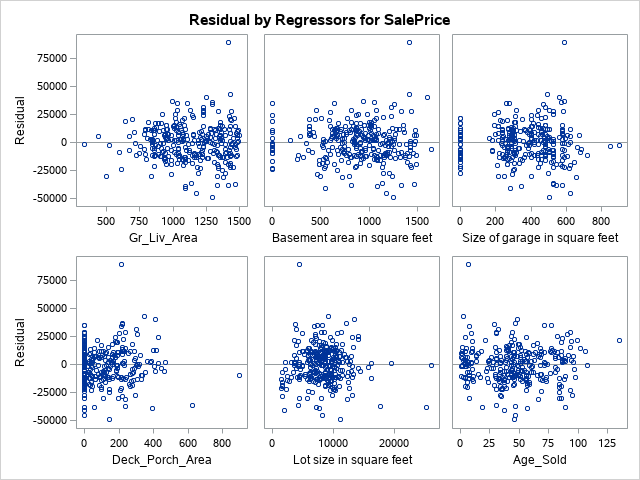
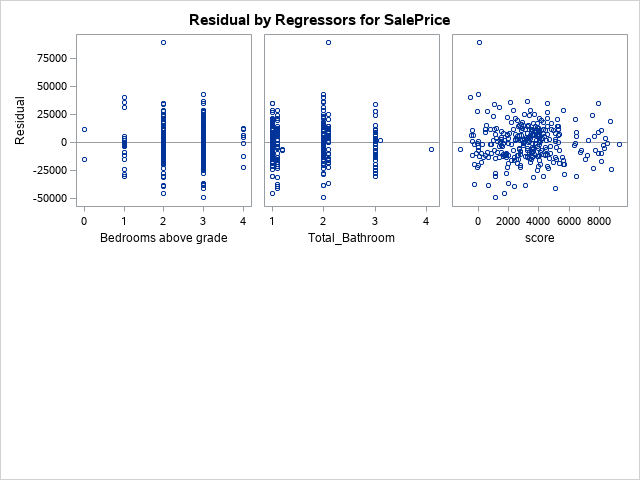
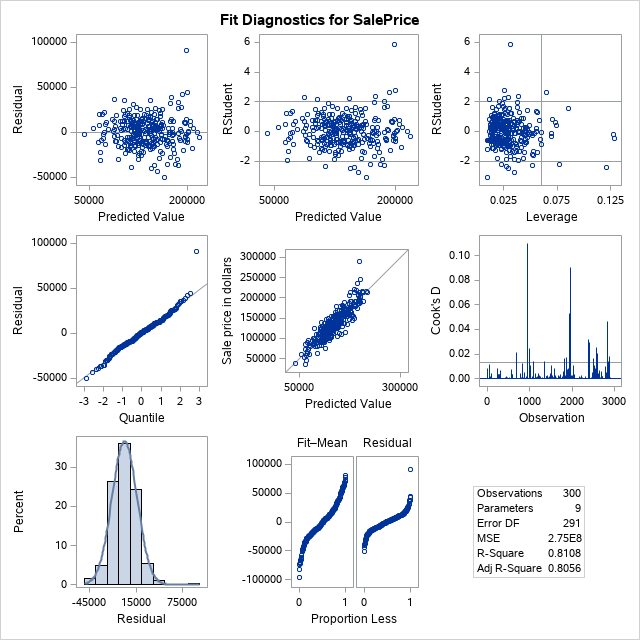
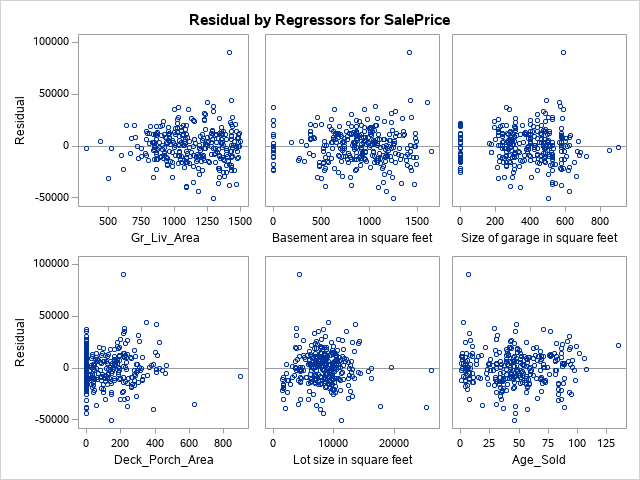
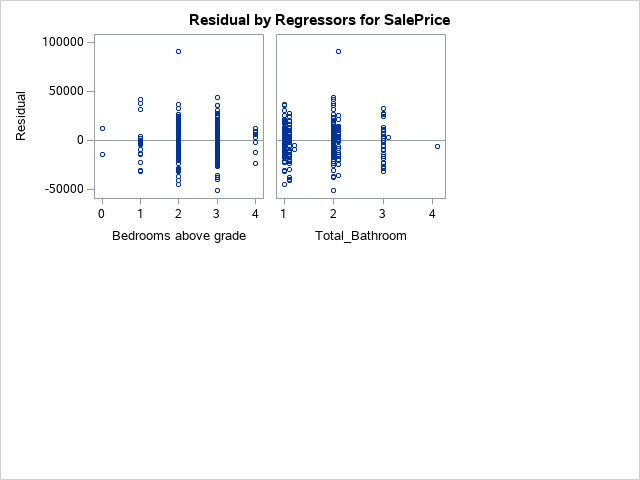

In [24]:
proc reg data=amescombined;
    WITHSCORE: model SalePrice = &interval score / vif;/*variance inflation factor, If the VIF is greater than 10 for any predictors in the model, those predictors are likely involved in collinearity.*/
    title 'Collinearity Diagnostics';
run;
quit;

proc reg data=amescombined;
    NOSCORE: model SalePrice = &interval / vif; 
    title2 'Removing Score';
run;
quit;

In the Model WITHSCORE The VIFs for Above Ground Living Area, Basement_Area, and score are much larger than 10, so a severe collinearity problem is present.

in the Model NOSCORE, The eight variables in question no longer exhibit a high degree of collinearity, and could now be safely passed into a stepwise selection approach.

#### Using an Effective Modeling Cycle

1. You want to get to know your data by **performing preliminary analyses**. You should plot your data, calculate descriptive statistics, and perform correlation analysis.
2. it's a good idea to **check for collinearity** before using any automated model selection techniques. This step can include the use of the correlation analyses and VIF statistics.
3. You use PROC REG or PROC GLMSELECT to **identify some good candidate models**. No perfect model exists, so find the best, or simply, the most useful one. To narrow your choices to a few good models, you can use all-possible regressions if you have few candidate predictors, or stepwise selection methods when you consider many predictors.
4. verifying **model assumptions and searching for possible influential observations**. You need to check and validate your assumptions by creating plots of residuals, and graphs of the residuals versus predicted values and predictors. To detect influential observations, you examine the RSTUDENT residuals, Cook's D statistic, DFFITS, and DFBETAS statistics.
5. you need to **revise your model if needed**. If Steps 3 and 4 indicate the need for model revision, generate a new model by returning to these two steps. The last step is prediction testing. You should try to validate your model with a holdout data set not used to build the model to see whether it generalizes well to new data sets. 
6. You'll learn about **prediction testing, and predictive modeling** in general, in the next lesson, when we move from inference to prediction.

#### Practice: Using the Linear Regression Task to Assess Collinearity

Run a regression of PctBodyFat2 on all the other numeric variables in the data set bodyfat2.

1. Write a PROC REG step to determine whether a collinearity problem exists in your model. Submit the code and view the results.

In [25]:
ods graphics off;
proc reg data=STAT1.BodyFat2;
   FULLMODL: model PctBodyFat2 = 
                   Age Weight Height
                   Neck Chest Abdomen Hip Thigh
                   Knee Ankle Biceps Forearm Wrist
                   / vif;
   title 'Collinearity -- Full Model';
run;
quit;
ods graphics on;

There seems to be high collinearity with Weight, Hip, and Abdomen. Chest and Thigh are below the cut off but are larger than the others that do not exceed 5.

2. If there is a collinearity problem, what would you like to do about it? Will you remove any variables? Why or why not?

In [26]:
ods graphics off;
proc reg data=STAT1.BodyFat2;
   NOWT: model PctBodyFat2 =
               Age Height
               Neck Chest Abdomen Hip Thigh
               Knee Ankle Biceps Forearm Wrist
               / vif;
   title 'Collinearity -- No Weight';
run;
quit;

ods graphics on;

The answer is not so easy. Weight is collinear with some of the other variables, but as you saw before in your model-building process, Weight is a relatively significant predictor in the "best" models. A subject-matter expert should determine the answer. If you want to remove Weight, simply run that model again without that variable.